<a href="https://colab.research.google.com/github/MehrdadDastouri/air_quality_monitor/blob/main/air_quality_monitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pandas numpy scikit-learn matplotlib seaborn nltk

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.5316 - mae: 0.5678 - val_loss: 0.0447 - val_mae: 0.1754
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1082 - mae: 0.2562 - val_loss: 0.0183 - val_mae: 0.1121
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0485 - mae: 0.1719 - val_loss: 0.0068 - val_mae: 0.0658
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0253 - mae: 0.1249 - val_loss: 0.0050 - val_mae: 0.0564
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0160 - mae: 0.0997 - val_loss: 0.0055 - val_mae: 0.0591
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0114 - mae: 0.0847 - val_loss: 0.0046 - val_mae: 0.0540
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0097 - mae: 0.0784 - val_loss: 0.0045 - val_mae: 0.0535
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0088 - mae: 0.0747 - val_loss: 0.0046 - val_mae: 0.0539
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step -

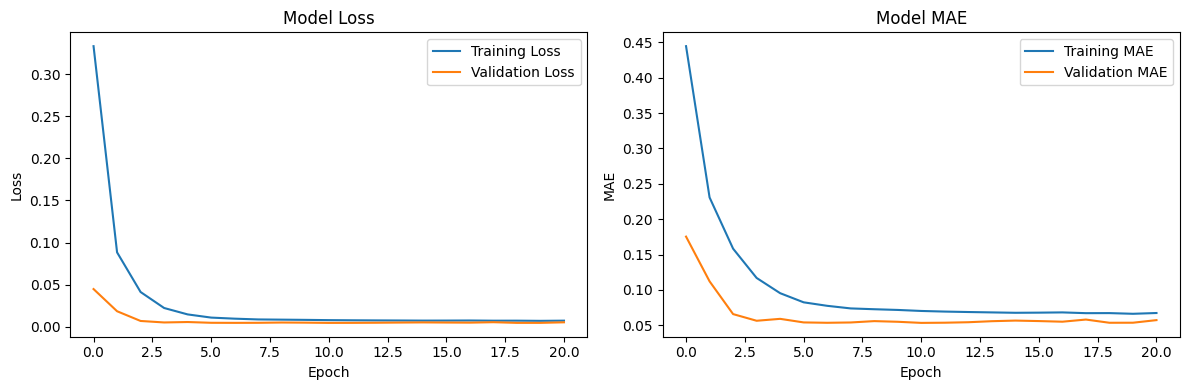

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


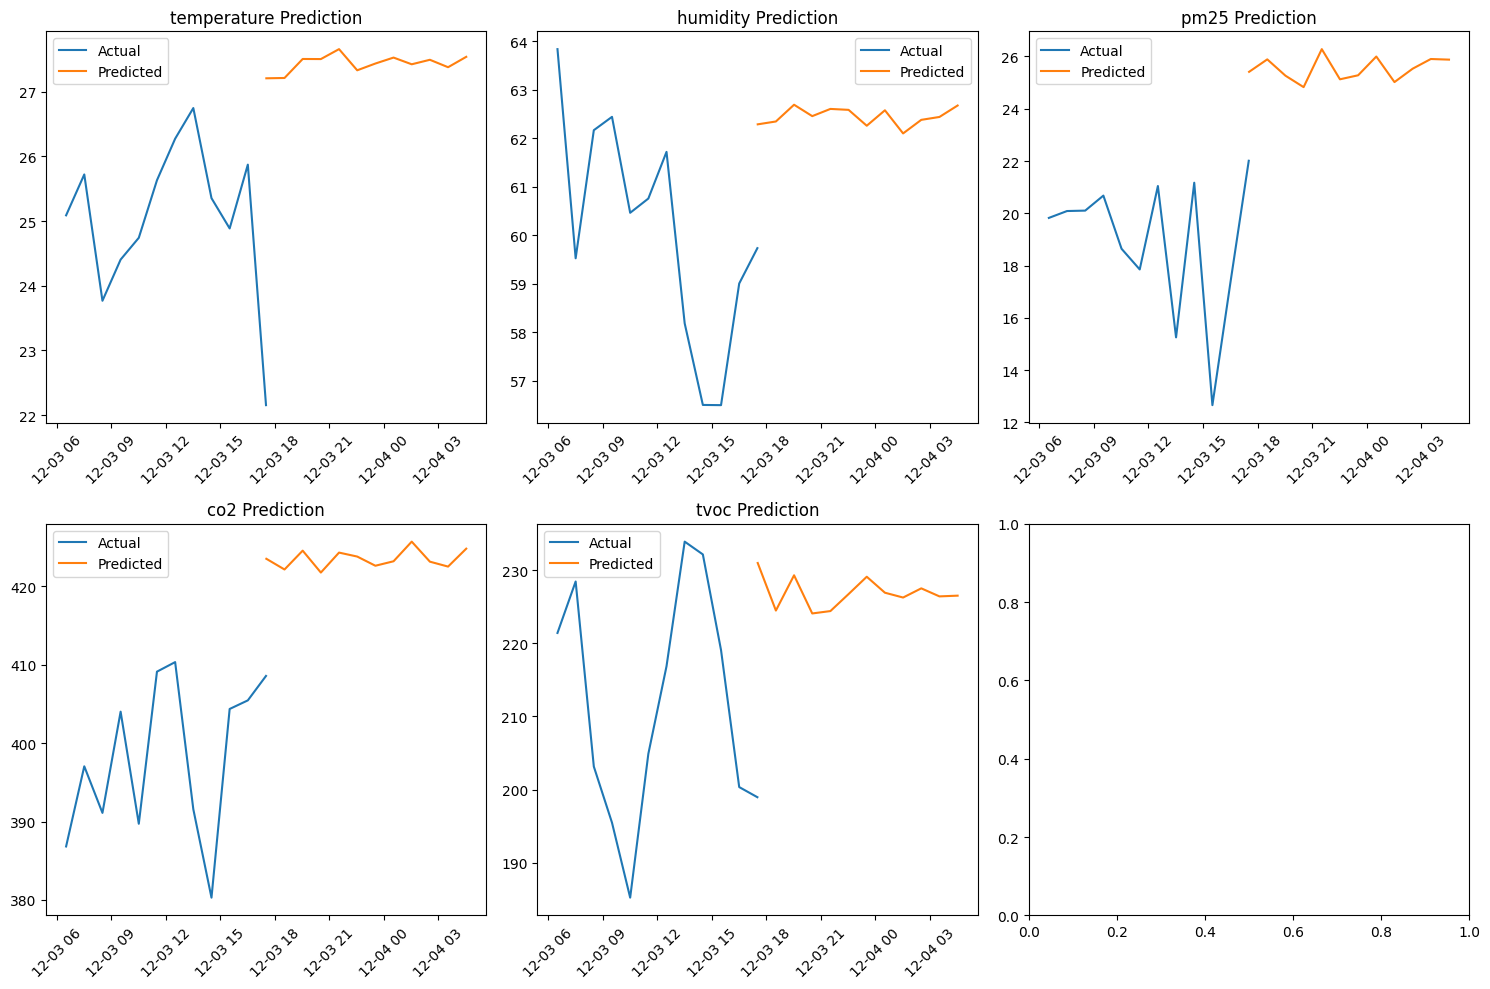


Predicted Air Quality Parameters:
                            temperature   humidity       pm25         co2  \
2024-12-03 17:32:12.479057    27.208399  62.285793  25.412695  423.514313   
2024-12-03 18:32:12.479057    27.213297  62.344532  25.889593  422.149719   
2024-12-03 19:32:12.479057    27.507069  62.689659  25.265606  424.552673   
2024-12-03 20:32:12.479057    27.505632  62.454815  24.827509  421.756775   
2024-12-03 21:32:12.479057    27.659283  62.603188  26.281355  424.304657   
2024-12-03 22:32:12.479057    27.332102  62.583958  25.126934  423.799316   
2024-12-03 23:32:12.479057    27.436647  62.256947  25.280596  422.627380   
2024-12-04 00:32:12.479057    27.528690  62.575073  25.998487  423.196808   
2024-12-04 01:32:12.479057    27.425074  62.098652  25.020594  425.702271   
2024-12-04 02:32:12.479057    27.494608  62.378082  25.532698  423.146149   
2024-12-04 03:32:12.479057    27.379644  62.437630  25.903423  422.519318   
2024-12-04 04:32:12.479057    27.540245  

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import json
from typing import Dict, List, Tuple, Optional
import logging

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

class AirQualityMonitor:
    """Intelligent Air Quality Monitoring and Prediction System"""

    def __init__(self, config_path: Optional[str] = None):
        """Initialize the Air Quality Monitor with optional configuration."""
        self.config = self._load_config(config_path)
        self.scaler = MinMaxScaler()
        self.model = None
        self.history = None
        self.logger = logging.getLogger(__name__)

    def _load_config(self, config_path: Optional[str]) -> Dict:
        """Load configuration from JSON file or use default values."""
        default_config = {
            "sequence_length": 24,
            "future_steps": 12,
            "lstm_units": [128, 64],
            "dropout_rate": 0.2,
            "learning_rate": 0.001,
            "epochs": 50,
            "batch_size": 32
        }

        if config_path:
            try:
                with open(config_path, 'r') as f:
                    return json.load(f)
            except Exception as e:
                self.logger.warning(f"Failed to load config: {e}. Using default config.")

        return default_config

    def generate_synthetic_data(self, days: int = 365) -> pd.DataFrame:
        """Generate synthetic IoT sensor data for air quality parameters."""
        dates = pd.date_range(
            start=datetime.now() - timedelta(days=days),
            end=datetime.now(),
            freq='H'
        )

        # Generate synthetic data with daily and seasonal patterns
        n_samples = len(dates)

        data = {
            'timestamp': dates,
            'temperature': 25 + 5 * np.sin(np.linspace(0, 4*np.pi, n_samples)) + \
                         np.random.normal(0, 1, n_samples),
            'humidity': 60 + 10 * np.sin(np.linspace(0, 2*np.pi, n_samples)) + \
                       np.random.normal(0, 2, n_samples),
            'pm25': 20 + 10 * np.sin(np.linspace(0, 6*np.pi, n_samples)) + \
                    np.random.normal(0, 3, n_samples),
            'co2': 400 + 50 * np.sin(np.linspace(0, 4*np.pi, n_samples)) + \
                   np.random.normal(0, 10, n_samples),
            'tvoc': 200 + 100 * np.sin(np.linspace(0, 3*np.pi, n_samples)) + \
                    np.random.normal(0, 20, n_samples)
        }

        df = pd.DataFrame(data)
        df.set_index('timestamp', inplace=True)
        return df

    def prepare_sequences(self, data: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """Prepare sequences for LSTM model."""
        scaled_data = self.scaler.fit_transform(data)
        X, y = [], []

        for i in range(len(scaled_data) - self.config['sequence_length'] - \
                      self.config['future_steps'] + 1):
            X.append(scaled_data[i:(i + self.config['sequence_length'])])
            y.append(scaled_data[i + self.config['sequence_length']:
                               i + self.config['sequence_length'] + \
                               self.config['future_steps']])

        return np.array(X), np.array(y)

    def build_model(self, input_shape: Tuple[int, int]) -> None:
        """Build LSTM model architecture."""
        self.model = Sequential()

        # First LSTM layer
        self.model.add(LSTM(
            self.config['lstm_units'][0],
            return_sequences=True,
            input_shape=input_shape
        ))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(self.config['dropout_rate']))

        # Second LSTM layer
        self.model.add(LSTM(
            self.config['lstm_units'][1],
            return_sequences=False
        ))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(self.config['dropout_rate']))

        # Output layer
        self.model.add(Dense(self.config['future_steps'] * input_shape[1]))

        # Reshape output to match target shape
        self.model.add(tf.keras.layers.Reshape(
            (self.config['future_steps'], input_shape[1])
        ))

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.config['learning_rate'])
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def train_model(self, X_train: np.ndarray, y_train: np.ndarray,
                    X_val: np.ndarray, y_val: np.ndarray) -> None:
        """Train the LSTM model."""
        self.history = self.model.fit(
            X_train, y_train,
            epochs=self.config['epochs'],
            batch_size=self.config['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=10,
                    restore_best_weights=True
                )
            ]
        )

    def predict_future(self, last_sequence: np.ndarray) -> pd.DataFrame:
        """Predict future air quality parameters."""
        scaled_prediction = self.model.predict(last_sequence)
        prediction = self.scaler.inverse_transform(scaled_prediction[0])

        future_dates = pd.date_range(
            start=datetime.now(),
            periods=self.config['future_steps'],
            freq='H'
        )

        return pd.DataFrame(
            prediction,
            index=future_dates,
            columns=['temperature', 'humidity', 'pm25', 'co2', 'tvoc']
        )

    def plot_training_history(self) -> None:
        """Plot training history."""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['mae'], label='Training MAE')
        plt.plot(self.history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, actual: pd.DataFrame, predicted: pd.DataFrame) -> None:
        """Plot actual vs predicted values."""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for idx, column in enumerate(actual.columns):
            if idx < len(axes):
                axes[idx].plot(actual.index, actual[column], label='Actual')
                axes[idx].plot(predicted.index, predicted[column], label='Predicted')
                axes[idx].set_title(f'{column} Prediction')
                axes[idx].legend()
                axes[idx].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

def main():
    # Initialize the monitor
    monitor = AirQualityMonitor()

    # Generate synthetic data
    data = monitor.generate_synthetic_data()

    # Prepare sequences
    X, y = monitor.prepare_sequences(data)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Build and train model
    monitor.build_model(input_shape=(X.shape[1], X.shape[2]))
    monitor.train_model(X_train, y_train, X_test, y_test)

    # Plot training history
    monitor.plot_training_history()

    # Make predictions
    last_sequence = X_test[-1:]
    predictions = monitor.predict_future(last_sequence)

    # Plot actual vs predicted
    actual_data = data.iloc[-monitor.config['future_steps']:]
    monitor.plot_predictions(actual_data, predictions)

    # Print predictions
    print("\nPredicted Air Quality Parameters:")
    print(predictions)

if __name__ == "__main__":
    main()